# An Exploratory Data Analysis on Movie Data by Nathaniel Green

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 
import cpi

In [3]:
# importing movie budget data
budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
#Transforming budget and gross columns in integers
budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']] = budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']].applymap(lambda x: int(x.replace('$','').replace(",", "")))
budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']] = budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']].applymap(lambda x: x/1000000)
#creating profit columns to see the return on budget investment for each movie
budgets["profit_worldwide"] = budgets["worldwide_gross"] - budgets["production_budget"]
budgets["profit_domestic"] = budgets["domestic_gross"] - budgets["production_budget"]
budgets["profit_international"] = (budgets["worldwide_gross"] - budgets["domestic_gross"]) - budgets["production_budget"]
#Transforming release_date column to datetime data
budgets.release_date = pd.to_datetime(budgets.release_date)
#Creating Columns for Day, Month and Year of release
budgets['Month'] = budgets.release_date.dt.month
budgets["Year"] = budgets.release_date.dt.year
budgets["Day"] = budgets.release_date.dt.dayofweek
Day = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday" 
}
budgets["Day"] = budgets["Day"].map(Day)
#Adjusting worldwide profit and production budget for inflation
budgets["adjusted_profit_ww"] = budgets.apply(lambda x: cpi.inflate(x["profit_worldwide"], x["Year"]), axis = 1)
budgets["adjusted_budget"] = budgets.apply(lambda x: cpi.inflate(x["production_budget"], x["Year"]), axis = 1)
#Using inflation ajusted data to find the Return on Investment for each row
budgets["ROI"] = (budgets["adjusted_profit_ww"]/ budgets["adjusted_budget"]) *100


In [4]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI
0,1,2009-12-18,Avatar,425.0,760.507625,2776.345279,2351.345279,335.507625,1590.837654,12,2009,Friday,2969.856157,536.794352,553.257713
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410.6,241.063875,1045.663875,635.063875,-169.536125,394.000000,5,2011,Friday,765.021887,494.624240,154.667286
2,3,2019-06-07,Dark Phoenix,350.0,42.762350,149.762350,-200.237650,-307.237650,-243.000000,6,2019,Friday,-212.231216,370.963830,-57.210757
3,4,2015-05-01,Avengers: Age of Ultron,330.6,459.005868,1403.013963,1072.413963,128.405868,613.408095,5,2015,Friday,1226.038687,377.958889,324.384139
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317.0,620.181382,1316.721747,999.721747,303.181382,379.540365,12,2017,Friday,1105.150954,350.430361,315.369636


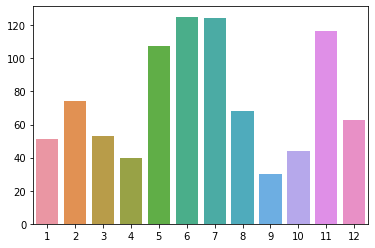

In [5]:
#Bar graph looking at average net gross per month
budgets_dict = budgets.groupby("Month").median()["ROI"].to_dict()
x = [k for k,v in budgets_dict.items()]
y = [v for k,v in budgets_dict.items()]

sns.barplot(x = x, y = y, data = budgets)
plt.show()

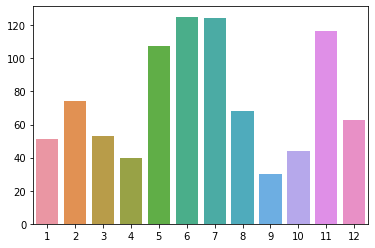

,Month,adjusted_profit_ww
0,1,8.909668
1,2,15.875356
2,3,12.211976
3,4,6.304882
4,5,23.904693
5,6,41.493704
6,7,35.650371
7,8,10.557417
8,9,1.970653
9,10,4.606761


In [6]:
#Bar graph looking at average net gross per month
ww_profit_dict = budgets.groupby("Month").median()[["adjusted_profit_ww"]]
x = [k for k,v in budgets_dict.items()]
y = [v for k,v in budgets_dict.items()]

sns.barplot(x = x, y = y, data = budgets)
plt.show()


ww_profit = ww_profit_dict[["adjusted_profit_ww"]].reset_index()
ww_profit

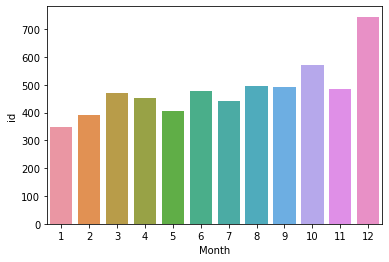

In [7]:
#Movie count per month
movie_per_month = budgets.groupby('Month').count()["id"].reset_index()
movie_per_month
sns.barplot(x = "Month", y = "id", data = movie_per_month)
plt.show()

In [8]:
movie_per_month.rename(columns = {"id":"number of movies"}, inplace = True)
movie_per_month["profit_per_month"] = [8.909668, 15.875356, 12.211976, 6.304882, 23.904693, 41.493704, 35.650371, 10.557417, 1.970653, 4.606761, 36.546961, 13.274991]
movie_per_month.corr()

,Month,number of movies,profit_per_month
Month,1.000000,0.794066,0.105586
number of movies,0.794066,1.000000,-0.140149
profit_per_month,0.105586,-0.140149,1.000000


In [9]:
#importing basics data from imdb database
conn = sqlite3.connect('data/im2.db')
cursor_obj = conn.cursor()

basics = pd.read_sql("""
SELECT*
FROM movie_basics;

""", conn)

basics.drop(columns =["original_title", "movie_id", "start_year"], inplace = True)
basics = basics.rename(columns = {"primary_title": "movie"})


In [10]:
#Looing at value counts for each movie title
basics['movie'].value_counts()

Home                                          24
Broken                                        20
The Return                                    20
Alone                                         16
Homecoming                                    16
                                              ..
Miraklet i Viskan                              1
MozeL                                          1
Amigos Del Tren                                1
The Great Chicken Wing Hunt                    1
Caged Men: Tales from Chicago's SRO Hotels     1
Name: movie, Length: 136071, dtype: int64

In [11]:
#merging data and removing duplicate titles
basic_budget = pd.merge(budgets, basics, how="left", on = "movie")
basic_budget.drop_duplicates(subset = ['movie', 'Year'], inplace = True)

In [12]:
basic_budget["movie"].value_counts()
basic_budget[basic_budget["movie"] == "Home"]


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI,runtime_minutes,genres
274,44,2015-03-27,Home,130.0,177.39751,385.997896,255.997896,47.39751,78.600386,3,2015,Friday,292.669935,148.622673,196.921458,76.0,Drama
4259,56,2009-06-05,Home,12.0,0.00000,0.000000,-12.000000,-12.00000,-12.000000,6,2009,Friday,-15.156546,15.156546,-100.000000,76.0,Drama


In [13]:
#Exploding genres column
bb_cg = basic_budget.dropna(subset = ["genres"])
bb_cg.loc[: ,"genres"] = bb_cg.loc[: , "genres"].apply(lambda x: str(x).split(","))

/Users/nathanielgreen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
pd.set_option('display.max_rows', None)
bb_cg["genres"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Drama]                                194
[Documentary]                          100
[Comedy]                                85
[Comedy, Drama]                         73
[Adventure, Animation, Comedy]          67
[Comedy, Drama, Romance]                66
[Drama, Romance]                        59
[Action, Adventure, Sci-Fi]             57
[Horror]                                50
[Action, Crime, Drama]                  48
[Comedy, Romance]                       45
[Drama, Thriller]                       41
[Action, Adventure, Fantasy]            40
[Horror, Thriller]                      39
[Horror, Mystery, Thriller]             36
[Thriller]                              32
[Action, Comedy, Crime]                 32
[Action, Adventure, Comedy]             31
[Action, Adventure, Drama]              31
[Crime, Drama, Thriller]                28
[Action, Crime, Thriller]               25
[Biography, Drama, History]             24
[Crime, Drama]                          23
[Action, Th

In [15]:
explode = bb_cg.explode("genres")

In [16]:
#Groupoing genres
explode["genres"].replace("Action", "Action/Adventure", inplace = True)
explode["genres"].replace("Adventure", "Action/Adventure", inplace = True)
explode["genres"].replace("Music", "Musical", inplace = True)
#dropping low genre counts
explode["genres"].replace("News", np.nan, inplace = True)
explode["genres"].replace("Reality-TV", np.nan, inplace = True)
explode["genres"].replace("Sport", np.nan, inplace = True)
explode.dropna(subset = ["genres"], inplace =True)
#Looking at value counts per genre
explode["genres"].value_counts()


Drama               1146
Action/Adventure     986
Comedy               665
Thriller             392
Crime                311
Horror               288
Romance              267
Documentary          189
Biography            179
Sci-Fi               176
Mystery              174
Fantasy              154
Family               135
Animation            122
Musical               84
History               63
War                   31
Western               16
Name: genres, dtype: int64

In [17]:
#reassigning Avatar to Action/Adventure
explode.at[0,"genres"] = "Action/Adventure"

In [18]:
explode.drop_duplicates(subset = ['movie', 'Year', "genres"], inplace = True)
explode[explode["movie"] == "Dark Phoenix"]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI,runtime_minutes,genres
2,3,2019-06-07,Dark Phoenix,350.0,42.76235,149.76235,-200.23765,-307.23765,-243.0,6,2019,Friday,-212.231216,370.96383,-57.210757,113.0,Action/Adventure
2,3,2019-06-07,Dark Phoenix,350.0,42.76235,149.76235,-200.23765,-307.23765,-243.0,6,2019,Friday,-212.231216,370.96383,-57.210757,113.0,Sci-Fi


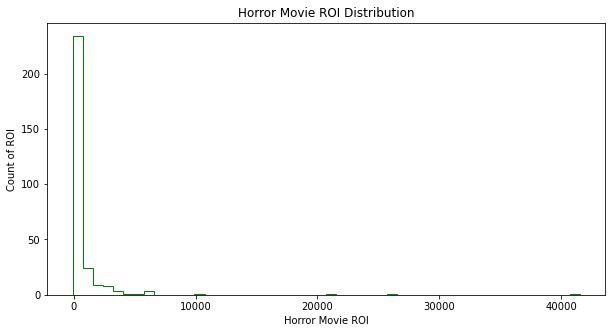

287

In [19]:
horror = explode.loc[(explode["genres"] == "Horror"), 'ROI']

count = horror.count()

fig, ax = plt.subplots(figsize = (10,5))
ax.hist(horror, bins = 50, histtype = 'step', color = 'green')
ax.set_xlabel('Horror Movie ROI')
ax.set_ylabel('Count of ROI' )
ax.set_title('Horror Movie ROI Distribution')

plt.show()

count




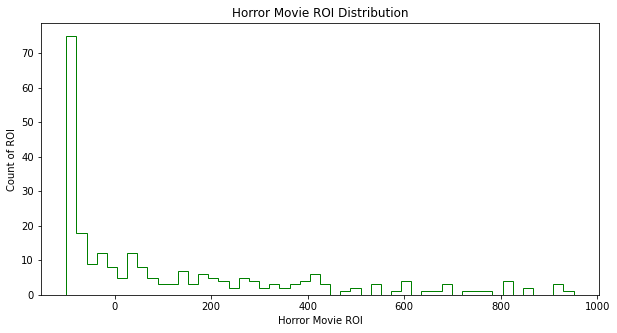

246

In [20]:
horror = explode.loc[(explode["genres"] == "Horror") & (explode["ROI"] < 1000), 'ROI']

count = horror.count()

fig, ax = plt.subplots(figsize = (10,5))
ax.hist(horror, bins = 50, histtype = 'step', color = 'green')
ax.set_xlabel('Horror Movie ROI')
ax.set_ylabel('Count of ROI' )
ax.set_title('Horror Movie ROI Distribution')

plt.show()

count

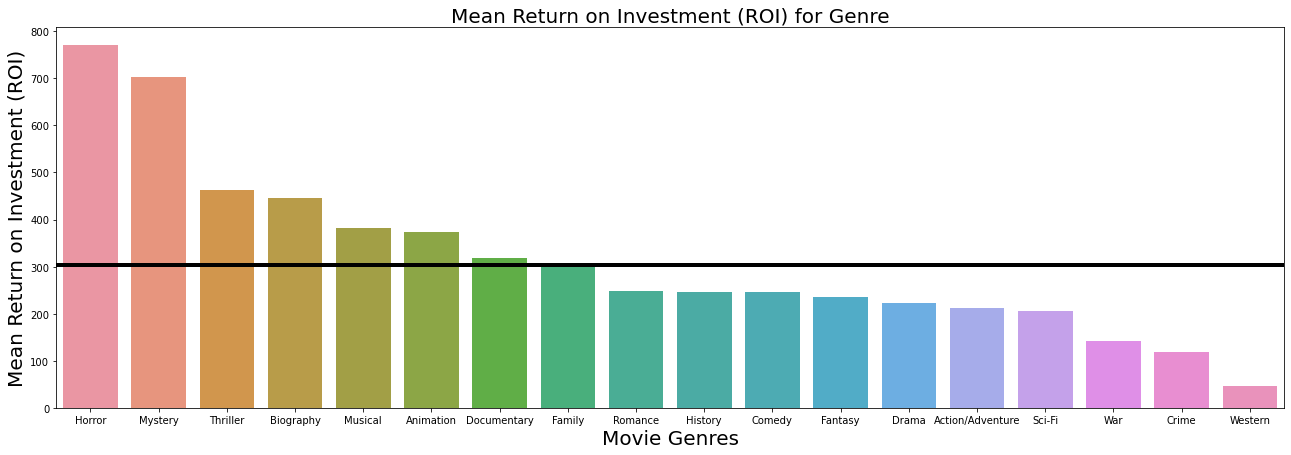

302.43803847837404

In [21]:
genre_mean_df = explode.groupby('genres').mean().sort_values(by = 'ROI', ascending = False)

fig, ax = plt.subplots(figsize = (22,7))

z = sns.barplot(x = genre_mean_df.index, y = genre_mean_df['ROI'])
z.axhline(explode["ROI"].mean(), linewidth=4, color = "black")
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Mean Return on Investment (ROI)', fontsize = 20)
plt.title("Mean Return on Investment (ROI) for Genre", fontsize = 20) 

plt.show()

explode["ROI"].mean()

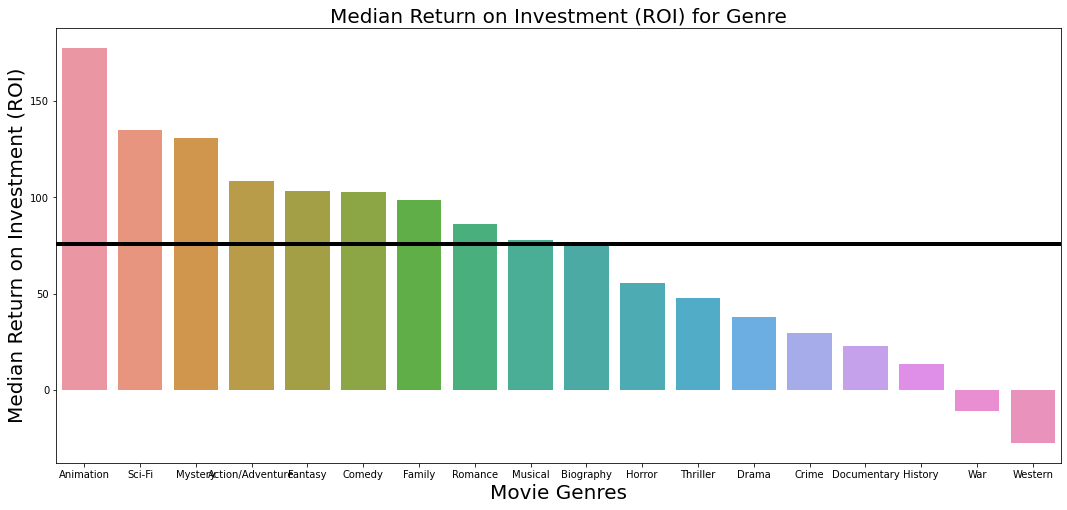

75.69172571428571

In [22]:
genre_med_df = explode.groupby('genres').median().sort_values(by = 'ROI', ascending = False)

fig, ax = plt.subplots(figsize = (18,8))

z = sns.barplot(x = genre_med_df.index, y = genre_med_df['ROI'])
z.axhline(explode["ROI"].median(), linewidth=4, color = "black")
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Median Return on Investment (ROI)', fontsize = 20)
plt.title("Median Return on Investment (ROI) for Genre", fontsize = 20) 

plt.show()

explode["ROI"].median()

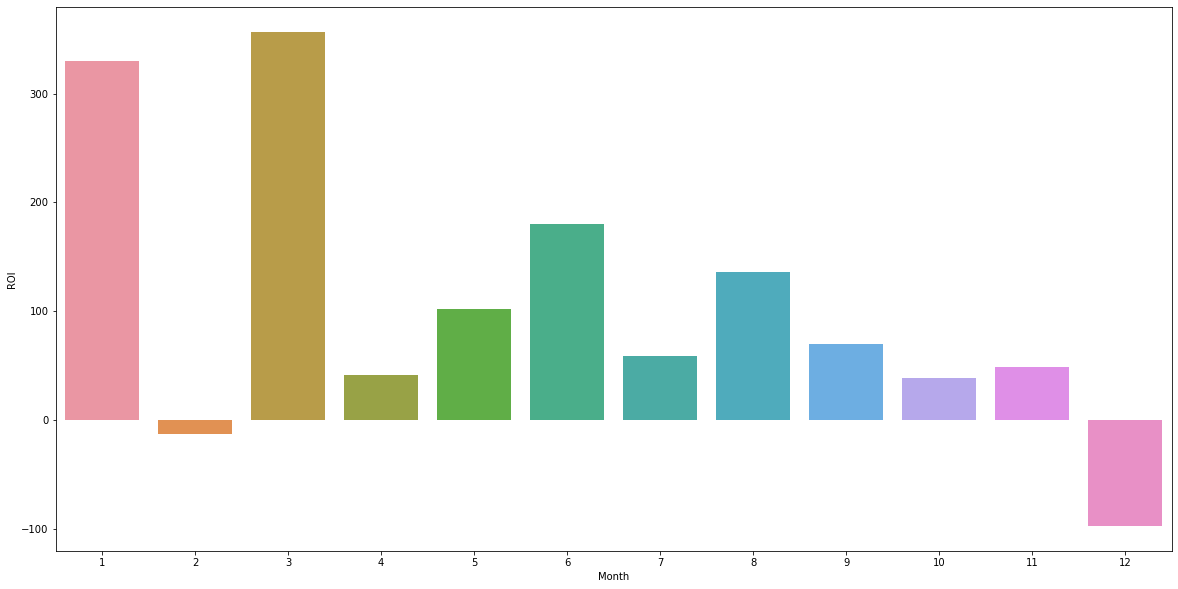

In [23]:
df_roi_month = explode[explode['genres'] =='Horror'].groupby('Month').median().reset_index()

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Month', y = 'ROI', data= df_roi_month);

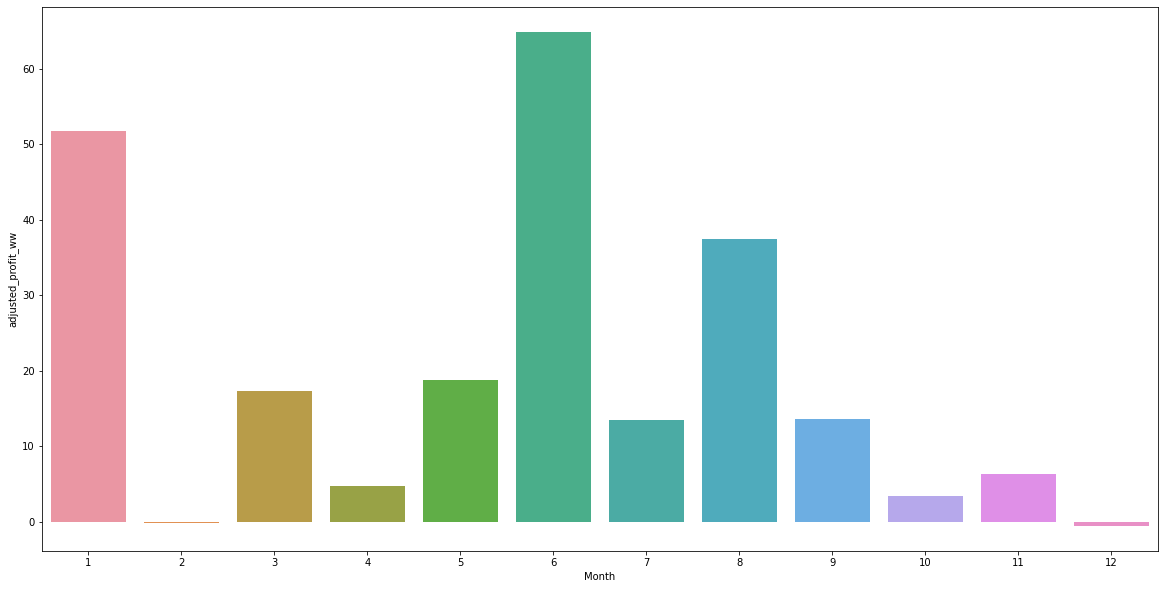

In [24]:
horror_profit_month = explode[explode['genres'] =='Horror'].groupby('Month').median().reset_index()

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Month', y = 'adjusted_profit_ww', data= horror_profit_month);

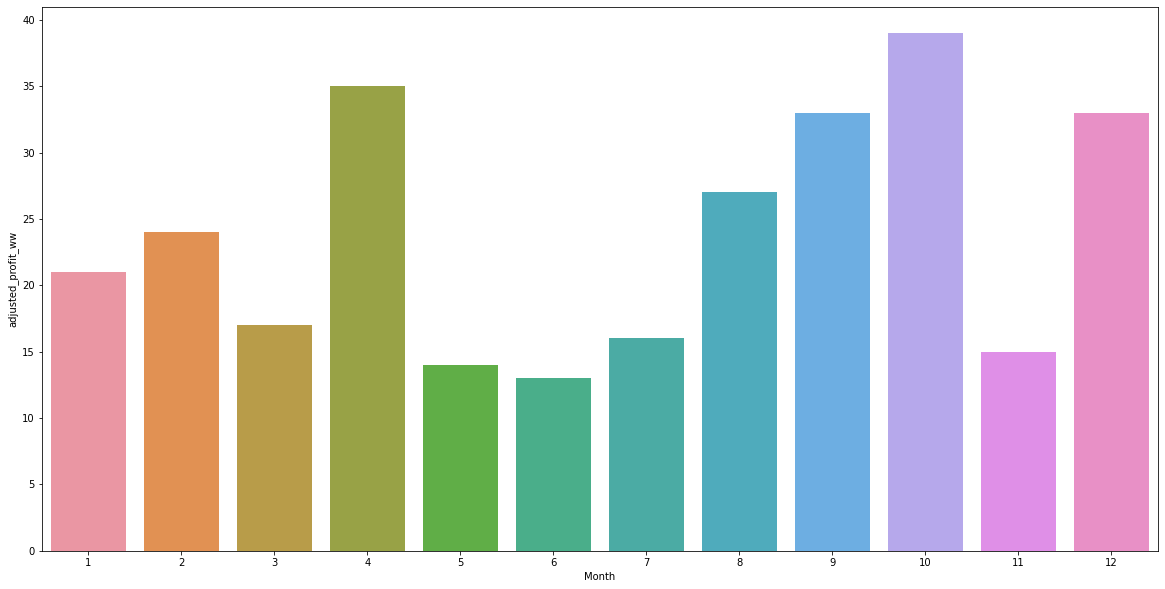

In [25]:
horror_per_month = explode[explode['genres'] =='Horror'].groupby('Month').count().reset_index()

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Month', y = 'adjusted_profit_ww', data= horror_per_month);

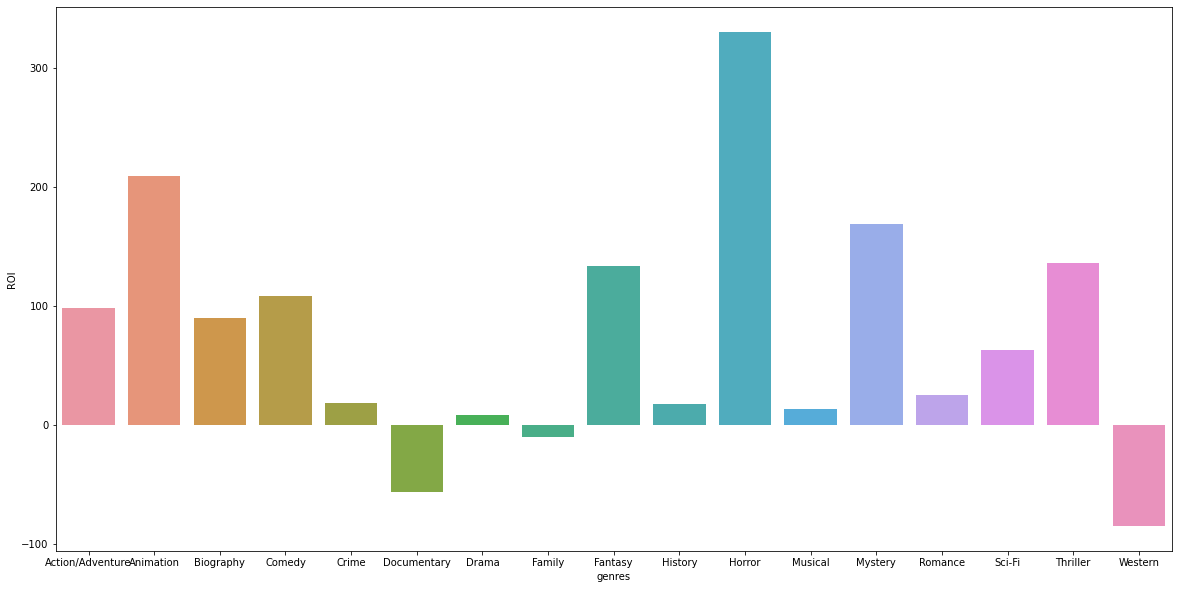

In [26]:
#January ROI per Genre
jan_roi = explode.loc[explode['Month'] == 1].groupby('genres')["ROI"].median().reset_index()

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'genres', y = 'ROI', data= jan_roi);

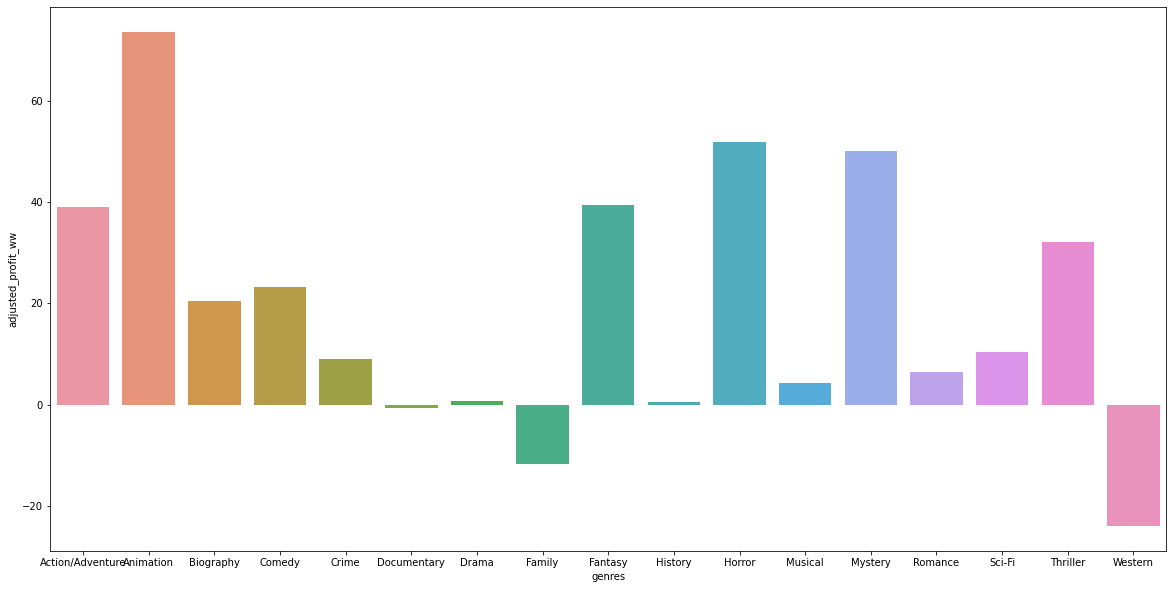

In [27]:
jan_profit = explode.loc[explode['Month'] == 1].groupby('genres')["adjusted_profit_ww"].median().reset_index()

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'genres', y = "adjusted_profit_ww", data= jan_profit);

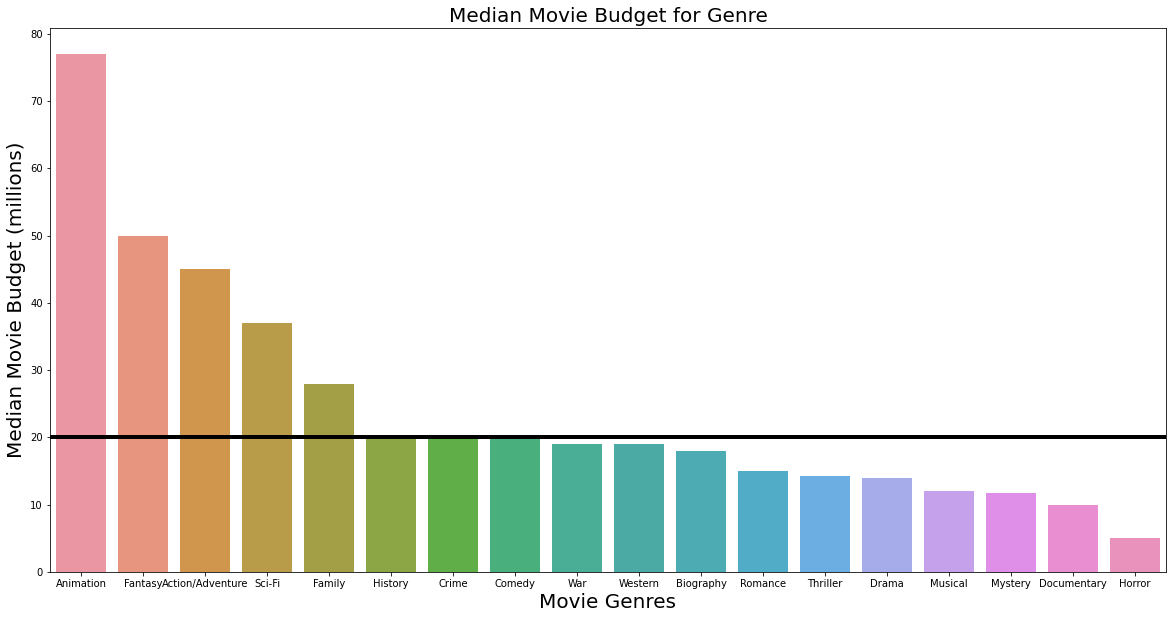

,id,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,adjusted_profit_ww,adjusted_budget,ROI,runtime_minutes
genres,,,,,,,,,,,,,
Animation,45.0,77.00,91.879935,247.621278,151.494094,5.523650,50.271827,7.0,2014.0,179.525787,85.798043,177.614470,93.0
Fantasy,51.5,50.00,37.381279,82.681624,32.750119,-4.823014,0.577764,6.0,2013.0,39.575800,59.329243,103.228583,108.0
Action/Adventure,50.0,45.00,43.482270,97.531134,44.100903,-3.000000,1.583235,7.0,2013.0,54.703647,55.919810,108.323185,105.0
Sci-Fi,55.0,37.00,39.749200,79.476526,29.571147,-0.499736,1.539904,6.0,2014.0,39.229266,45.232950,134.937340,108.0
Family,54.0,28.00,32.616869,48.446802,24.436778,-0.125000,-2.000000,8.0,2012.0,32.806724,32.911336,98.433845,99.0
History,43.0,20.00,8.323085,17.769299,0.350641,-4.218553,-3.409396,7.0,2015.0,0.441300,22.865027,13.602860,116.0
Crime,48.0,20.00,14.482031,27.317872,4.106975,-2.880612,-4.073253,7.0,2013.0,5.018494,24.853249,29.718960,106.0
Comedy,52.0,20.00,26.302731,43.603990,18.559999,-0.037715,-0.997177,7.0,2013.0,23.442124,24.853249,102.955240,100.0
War,49.0,19.00,6.485961,17.769299,-0.898947,-2.921052,-1.500000,6.0,2011.0,-1.028942,22.865027,-11.153505,111.0


In [28]:
genre_budget_df = explode.groupby('genres').median().sort_values(by = "production_budget", ascending = False)

fig, ax = plt.subplots(figsize = (20,10))
z = sns.barplot(x = genre_budget_df.index, y = genre_budget_df['production_budget'])
z.axhline(explode["production_budget"].median(), linewidth=4, color = "black")
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Median Movie Budget (millions)', fontsize = 20)
plt.title("Median Movie Budget for Genre", fontsize = 20) 

plt.show()

explode["production_budget"].median()
genre_budget_df


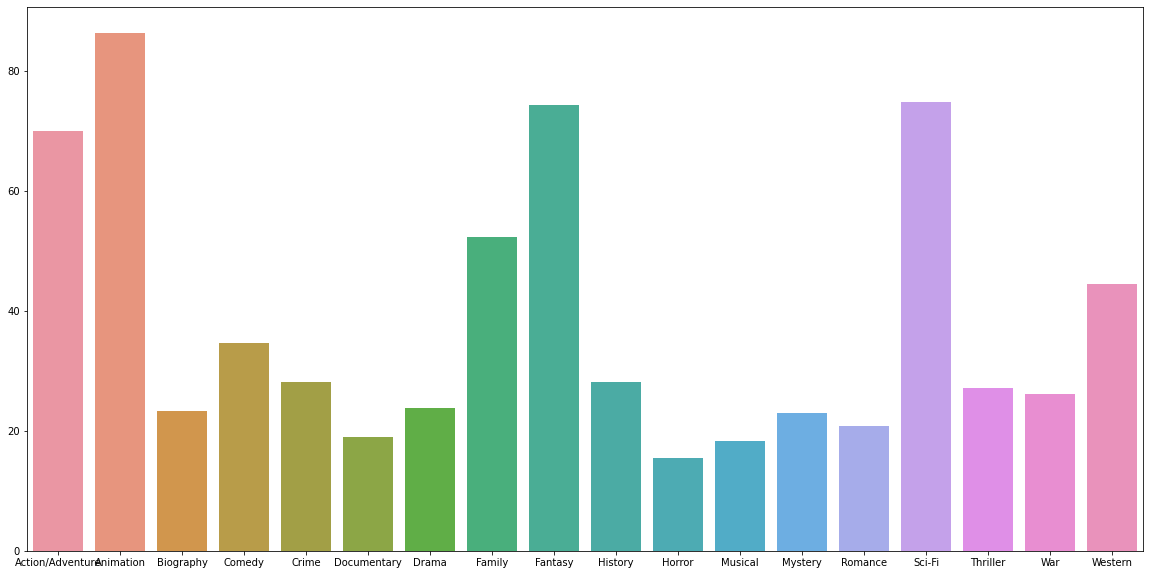

In [29]:
average_rating = explode.groupby("genres").mean()["production_budget"].to_dict()
x = [k for k,v in average_rating.items()]
y = [v for k,v in average_rating.items()]

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = x, y = y, data = explode)
plt.show()

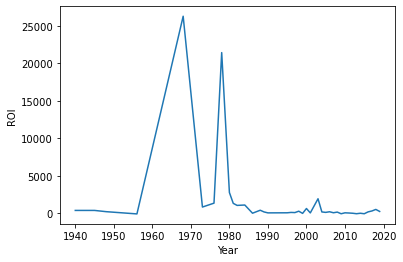

In [30]:
df_roi_year = explode[explode['genres'] =='Horror'].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

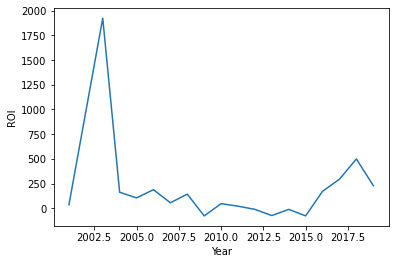

In [31]:
df_roi_year = explode[(explode['genres'] =='Horror') & (explode['Year']>2000)].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

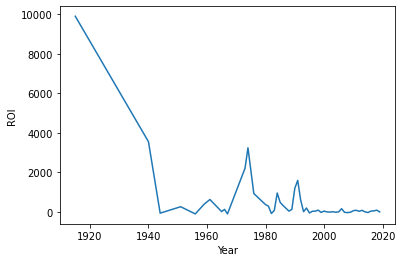

In [32]:
df_roi_year = explode[explode['genres'] =='Drama'].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

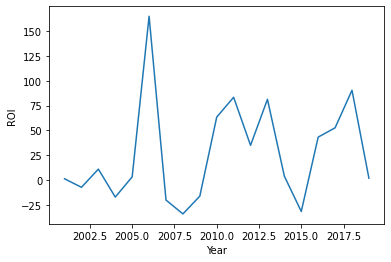

In [33]:
df_roi_year = explode[(explode['genres'] =='Drama') & (explode['Year']>2000)].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

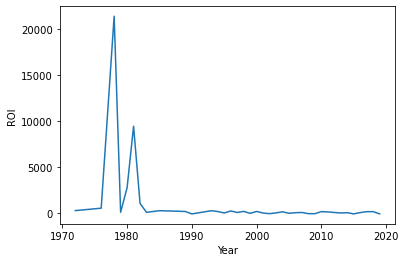

In [34]:
df_roi_year = explode[explode['genres'] =='Thriller'].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

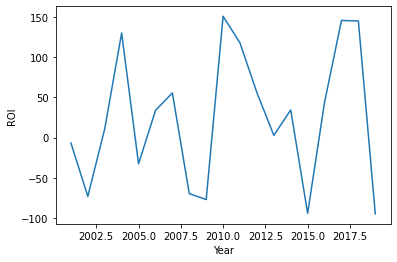

In [35]:
df_roi_year = explode[(explode['genres'] =='Thriller') & (explode['Year']>2000)].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

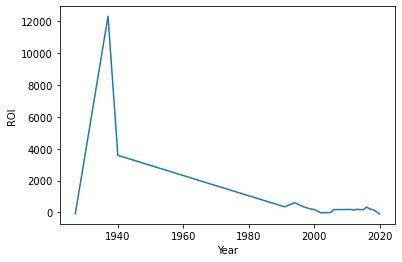

In [36]:
df_roi_year = explode[explode['genres'] =='Animation'].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

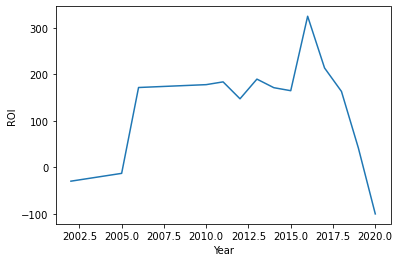

In [37]:
df_roi_year = explode[(explode['genres'] =='Animation') & (explode['Year']>2000)].groupby('Year').median().reset_index()


sns.lineplot(x = 'Year', y = 'ROI', data= df_roi_year);

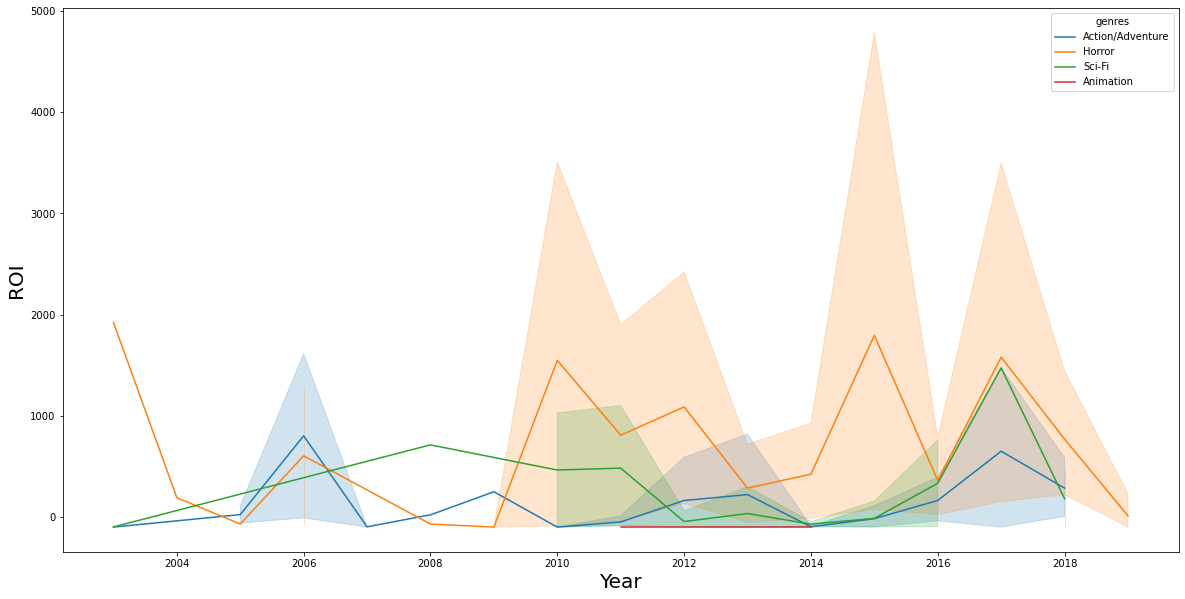

In [38]:
low_budget = explode["adjusted_budget"].quantile(q = 0.25)
data = explode.loc[((explode['genres'] =='Animation')|(explode['genres'] =='Horror')|(explode['genres'] =='Sci-Fi')|(explode['genres'] =='Action/Adventure')) & (explode["Year"] > 2000) & (explode["adjusted_budget"] < low_budget)]


fig, ax = plt.subplots(figsize = (20,10))
sns.lineplot(data=data, x = 'Year', y = 'ROI', hue = "genres");

data.sort_values(by = "ROI", ascending = False)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('ROI', fontsize = 20);

In [39]:
genre_counts = explode["genres"].value_counts().to_dict()
genre_counts 

{'Drama': 1146,
 'Action/Adventure': 763,
 'Comedy': 665,
 'Thriller': 392,
 'Crime': 311,
 'Horror': 287,
 'Romance': 267,
 'Documentary': 189,
 'Biography': 179,
 'Sci-Fi': 176,
 'Mystery': 174,
 'Fantasy': 154,
 'Family': 135,
 'Animation': 122,
 'Musical': 82,
 'History': 63,
 'War': 31,
 'Western': 16}

279.1370681378319

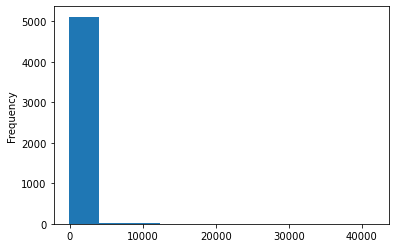

In [40]:
high_ROI = explode["ROI"].quantile(q = 0.75)
explode["ROI"].plot(kind='hist')

high_ROI


7.081282611914946

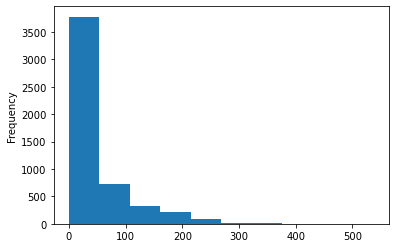

In [41]:
low_budget = explode["adjusted_budget"].quantile(q = 0.25)
explode["adjusted_budget"].plot(kind='hist')
low_budget

In [46]:
b_movie_counts

,Genre,Cult_Classic_Movies,Number_of_Movies,Cult_Classic_Percentage
0,Drama,76,1146,6.631763
1,Horror,44,287,15.331010
2,Comedy,32,665,4.812030
3,Thriller,29,392,7.397959
4,Romance,27,174,15.517241
5,Mystery,27,267,10.112360
6,Action/Adventure,14,987,1.418440
7,Documentary,10,176,5.681818
8,Sci-Fi,10,189,5.291005
9,Crime,9,179,5.027933


In [45]:
b_movie_df = explode.loc[(explode["ROI"] > high_ROI) & (explode["adjusted_budget"] < low_budget), "genres"]
b_movie_counts = b_movie_df.value_counts().reset_index()

b_movie_counts.rename(columns = {"index":"Genre", "genres":"Cult_Classic_Movies"}, inplace = True)
b_movie_counts['Number_of_Movies'] = [1146, 287, 665, 392, 174, 267, 987, 176, 189, 179, 311, 154, 84, 135, 63]
b_movie_counts["Cult_Classic_Percentage"] = b_movie_counts["Cult_Classic_Movies"]/ b_movie_counts["Number_of_Movies"]*100

Animation_Data = {"Genre": "Animation", "Cult_Classic_Movies": 0, "Number_of_Movies": 122, "Cult_Classic_Percentage": 0.0}
b_movie_counts = b_movie_counts.append(Animation_Data, ignore_index=True)

,Genre,Cult_Classic_Movies,Number_of_Movies,Cult_Classic_Percentage
0,Drama,76,1146,6.631763
1,Horror,44,287,15.331010
2,Comedy,32,665,4.812030
3,Thriller,29,392,7.397959
4,Romance,27,174,15.517241
5,Mystery,27,267,10.112360
6,Action/Adventure,14,987,1.418440
7,Documentary,10,176,5.681818
8,Sci-Fi,10,189,5.291005
9,Crime,9,179,5.027933


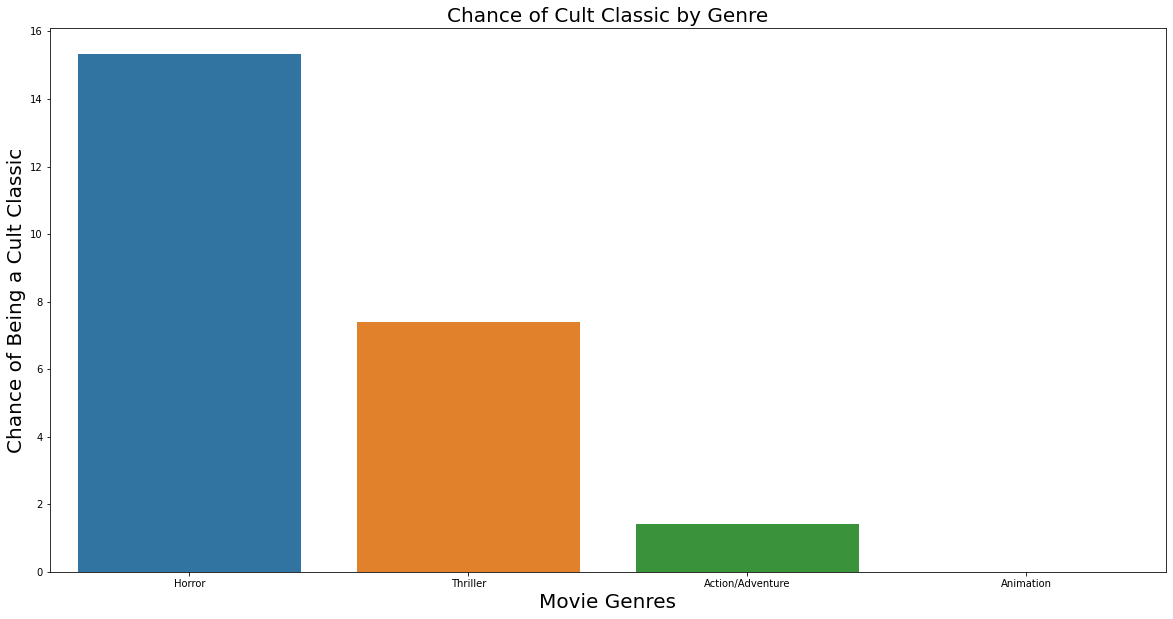

In [43]:
b_movie_counts
b_movies_top = b_movie_counts.loc[(b_movie_counts["Genre"] == "Horror")|(b_movie_counts["Genre"] == "Thriller")|(b_movie_counts["Genre"] == "Action/Adventure")| (b_movie_counts["Genre"] == "Animation")].reset_index()
b_movies_top.drop(columns = ["index"], inplace = True)
b_movies_top.sort_values(by = 'Cult_Classic_Percentage', ascending = False)

fig, ax = plt.subplots(figsize = (20,10))
ax = sns.barplot(x = 'Genre', y = 'Cult_Classic_Percentage', data= b_movies_top)
plt.title("Percent of Movies that Become Cult Classics by Genre");
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Chance of Being a Cult Classic', fontsize = 20)
plt.title("Chance of Cult Classic by Genre", fontsize = 20) 

b_movie_counts



/Users/nathanielgreen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-1022-359bf3552f69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_data.dropna(subset = ["worldwide_gross"], inplace =True)


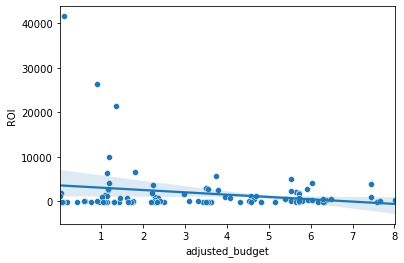

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI,runtime_minutes,genres
4964,14,2014-01-17,Devil's Due,7.000,15.821461,36.146087,29.146087,8.821461,13.324626,1,2014,Friday,33.360854,8.012258,416.372671,89.0,Horror
5037,84,2014-10-03,Annabelle,6.500,84.273813,256.862920,250.362920,77.773813,166.089107,10,2014,Friday,286.567486,7.439954,3851.737231,99.0,Horror
5101,36,2019-02-08,The Prodigy,6.000,14.856291,19.789712,13.789712,8.856291,-1.066579,2,2019,Friday,14.615670,6.359380,229.828533,92.0,Horror
5102,37,2018-11-30,The Possession of Hannah Grace,6.000,14.836174,42.785387,36.785387,8.836174,21.949213,11,2018,Friday,39.695175,6.474610,613.089783,86.0,Horror
5152,84,2009-05-08,Julia,6.000,0.065108,1.365108,-4.634892,-5.934892,-4.700000,5,2009,Friday,-5.854080,7.578273,-77.248200,95.0,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7102,80,2015-07-10,The Gallows,0.100,22.764410,41.656474,41.556474,22.664410,18.792064,7,2015,Friday,47.509494,0.114325,41556.474000,81.0,Horror
7136,6,2011-12-31,Absentia,0.070,0.000000,0.008555,-0.061445,-0.070000,-0.061445,12,2011,Saturday,-0.074019,0.084325,-87.778571,87.0,Horror
7163,32,2011-02-11,Raymond Did It,0.040,0.003632,0.003632,-0.036368,-0.036368,-0.040000,2,2011,Friday,-0.043810,0.048186,-90.920000,83.0,Horror
7182,49,2015-09-01,Exeter,0.025,0.000000,0.489792,0.464792,-0.025000,0.464792,9,2015,Tuesday,0.531374,0.028581,1859.168000,91.0,Horror


In [1022]:
horror_data = explode[explode["genres"] == "Horror"]
horror_data["worldwide_gross"].replace(0.0, np.nan, inplace = True)
horror_data.dropna(subset = ["worldwide_gross"], inplace =True)
horror_data2 = horror_data.loc[(horror_data["adjusted_budget"] < (median_budget/3))]
ax = sns.scatterplot(x = 'adjusted_budget', y = 'ROI', data = horror_data2)
line = sns.regplot(data= horror_data2, x="adjusted_budget", y='ROI', scatter=False, ax=ax)
plt.show();
horror_data2.corr()

horror_data2

In [1023]:
horror_data
is_multi = horror_data["movie"].value_counts() > 1
horror_remake = horror_data[horror_data["movie"].isin(is_multi[is_multi].index)]
horror_percent = len(horror_remake)/len(horror_data)*100

action_data = explode[explode["genres"] == "Action/Adventure"]
is_multi_action = action_data["movie"].value_counts() > 1
action_remake = action_data[action_data["movie"].isin(is_multi_action[is_multi_action].index)]
action_percent = (len(action_remake)/len(action_data))*100



In [1024]:
explode["Market Quarter"] = explode["Month"].apply(lambda x: "Q1" if x<4 else("Q2" if 3<x<6 else("Q3" if 5<x<9 else "Q4")))


In [1092]:
b_movie_df = explode.loc[(explode["ROI"] > high_ROI) & (explode["adjusted_budget"] < low_budget) & (explode["Market Quarter"] == "Q1"), "genres"]
b_movie_counts = b_movie_df.value_counts().reset_index()
b_movie_counts

,index,genres
0,Drama,21
1,Horror,14
2,Mystery,9
3,Thriller,7
4,Comedy,6
5,Biography,5
6,Romance,5
7,Sci-Fi,3
8,Action/Adventure,3
9,Fantasy,2


Text(0.5, 1.0, 'Movies Release Per Quarter')

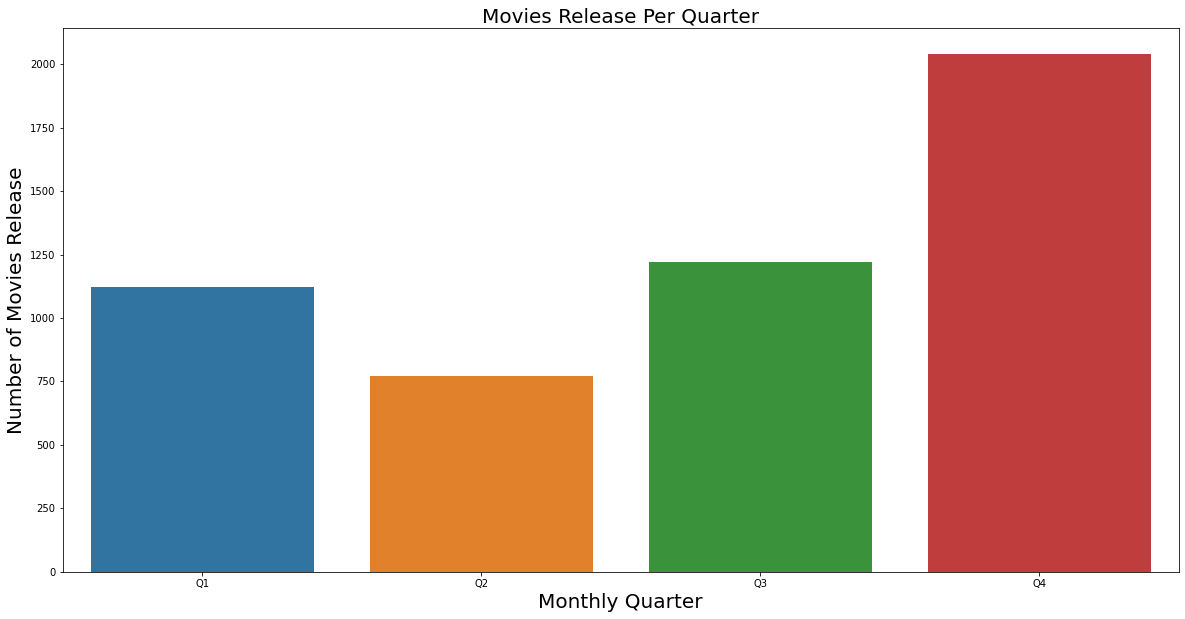

In [1025]:
quarter_count = explode.groupby('Market Quarter').count().reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'id', data= quarter_count)
plt.ylabel('Number of Movies Release', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Movies Release Per Quarter", fontsize = 20)


Text(0.5, 1.0, 'Movies Release Per Quarter')

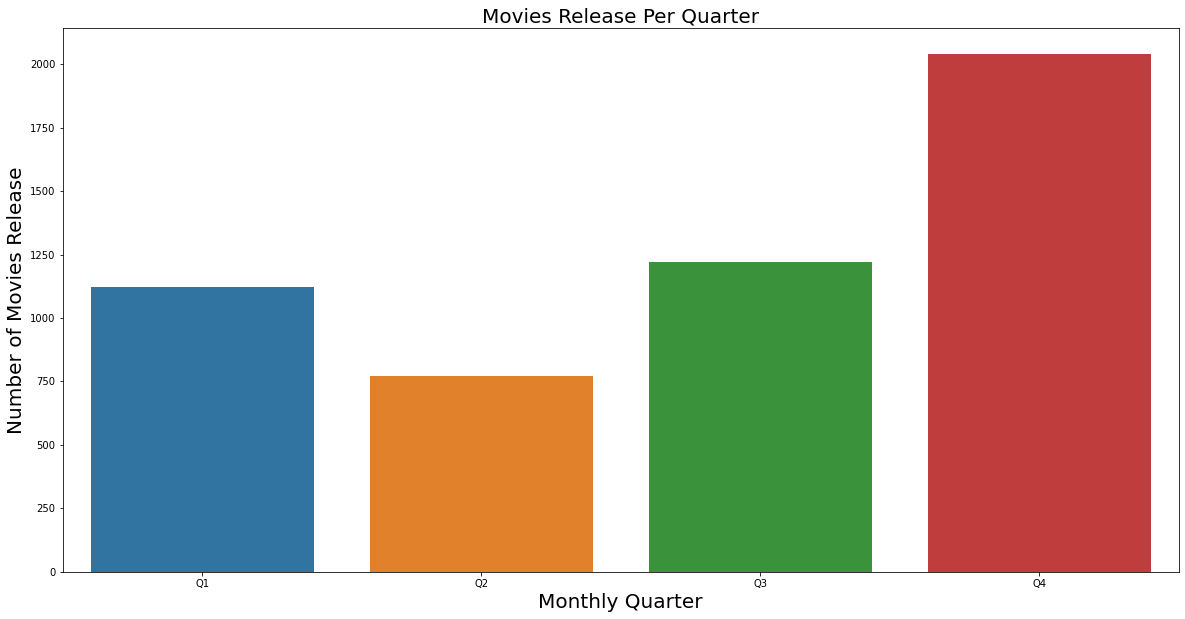

In [1026]:
quarter_count_horror = explode.loc[explode["genres"] == "Horror"].groupby('Market Quarter').count().reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'id', data= quarter_count)
plt.ylabel('Number of Movies Release', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Movies Release Per Quarter", fontsize = 20)

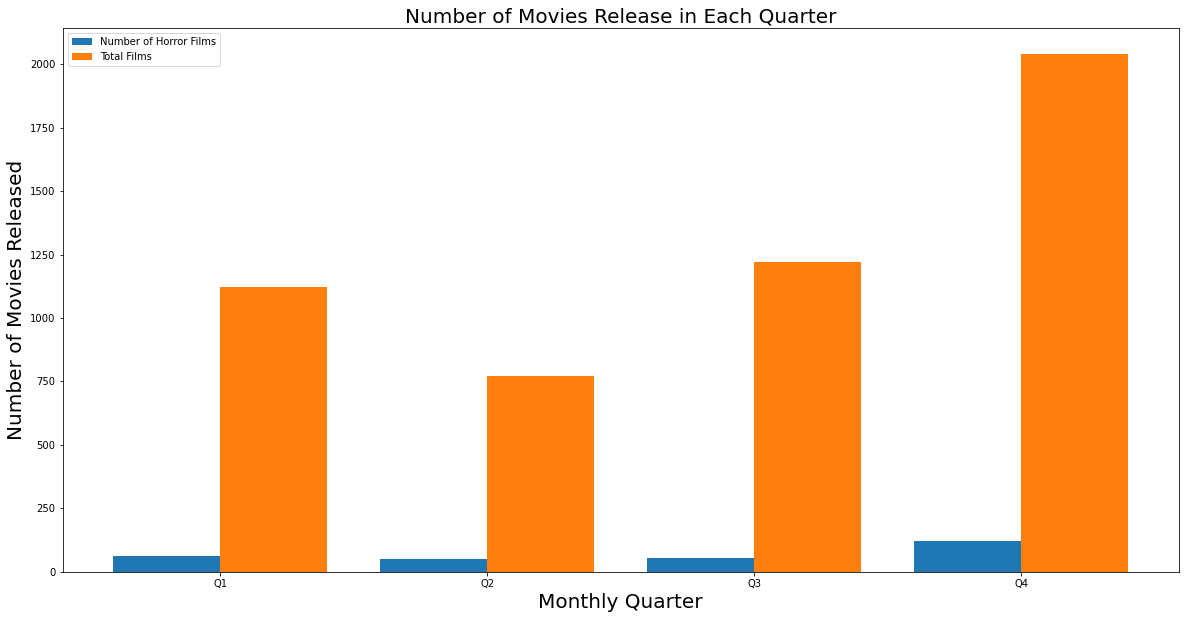

In [1027]:
quarter_count_horror = explode.loc[explode["genres"] == "Horror"].groupby('Market Quarter').count().reset_index()
Horror_count = quarter_count_horror[["Market Quarter", "id"]]
Horror_count = Horror_count.rename(columns = {"id": "Horror Movie Count"})

quarter_count = explode.groupby('Market Quarter').count().reset_index()
movie_count = quarter_count[["Market Quarter", "id"]]
movie_count = movie_count.rename(columns = {"id": "Total Movie Count"})

all_counts = pd.merge(movie_count, Horror_count, how = "left", on = "Market Quarter")


Horror_counts = Horror_count["Horror Movie Count"]
All_count = all_counts["Total Movie Count"]
fig, ax = plt.subplots(figsize = (20,10))
X_axis = np.arange(len(All_count))
plt.bar(X_axis - 0.2, Horror_counts, 0.4, label = 'Number of Horror Films')
plt.bar(X_axis + 0.2, All_count, 0.4, label = 'Total Films')
plt.xticks(X_axis, ["Q1", "Q2", "Q3", "Q4"])
plt.legend()
plt.ylabel('Number of Movies Released', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Number of Movies Release in Each Quarter", fontsize = 20);





Text(0.5, 1.0, 'Movies Release Per Quarter by Genre')

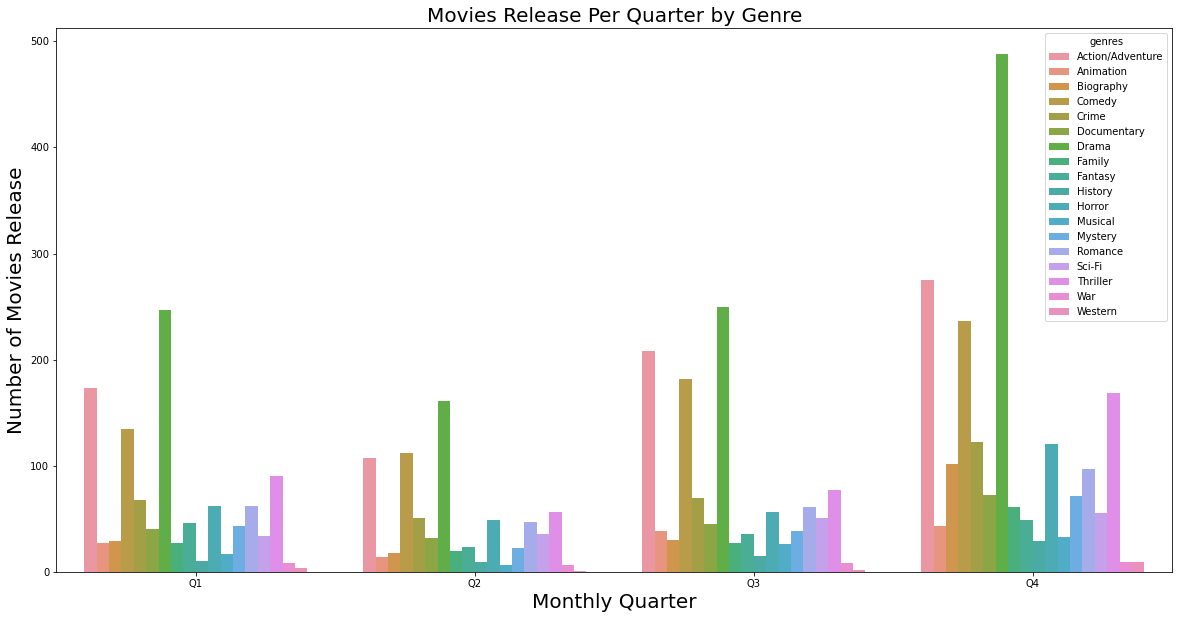

In [1028]:
quarter_count = explode.groupby(['Market Quarter', "genres"]).count().reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'id', hue = "genres", data= quarter_count)
plt.ylabel('Number of Movies Release', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Movies Release Per Quarter by Genre", fontsize = 20)


In [1029]:
quarter_ROI = explode[explode['genres']!='Horror'].groupby('Market Quarter').median().reset_index()
No_Horror_Data = quarter_ROI[["Market Quarter", "ROI"]]
No_Horror_Data.rename(columns = {"ROI": "No Horror ROI"}, inplace = True)
# fig, ax = plt.subplots(figsize = (20,10))
# sns.barplot(x = 'Market Quarter', y = 'ROI', data= quarter_ROI)
# plt.title("Movies Release Per Quarter", fontsize = 20)

/Users/nathanielgreen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


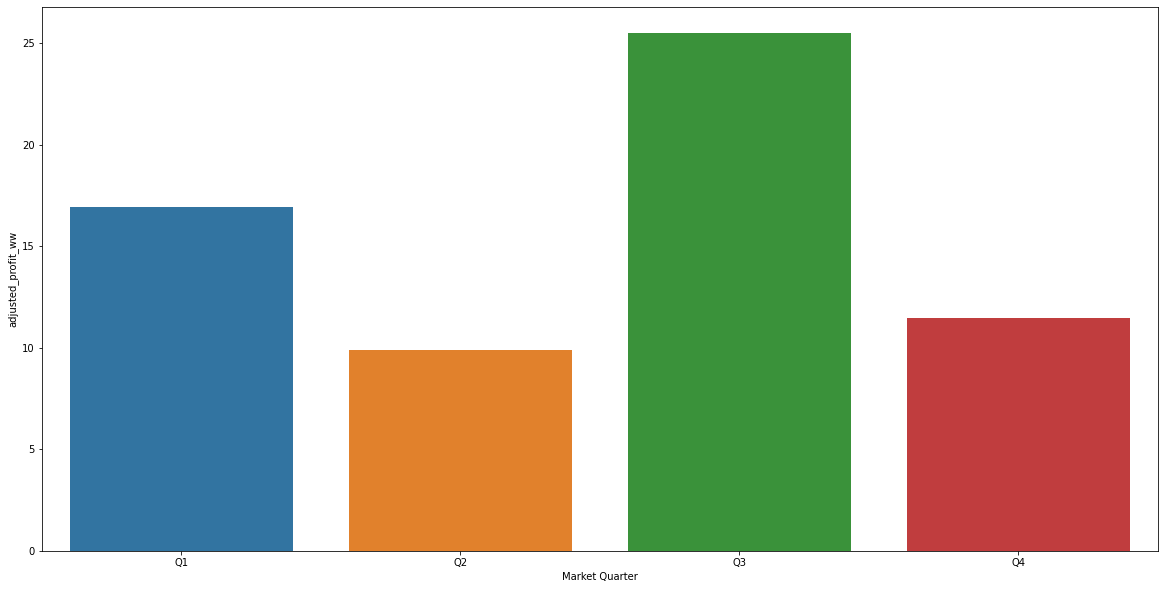

In [1030]:
quarter_profit = explode.groupby('Market Quarter').median().reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'adjusted_profit_ww', data= quarter_profit);

In [1031]:
quarter_horror_roi = explode[explode['genres'] =='Horror'].groupby('Market Quarter').median().reset_index()
Horror_data = quarter_horror_roi[["Market Quarter", "ROI"]]
Horror_data.rename(columns = {"ROI": "Horror ROI"}, inplace = True)
# fig, ax = plt.subplots(figsize = (20,10))
# sns.barplot(x = 'Market Quarter', y = 'ROI', data= quarter_horror_roi);

/Users/nathanielgreen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


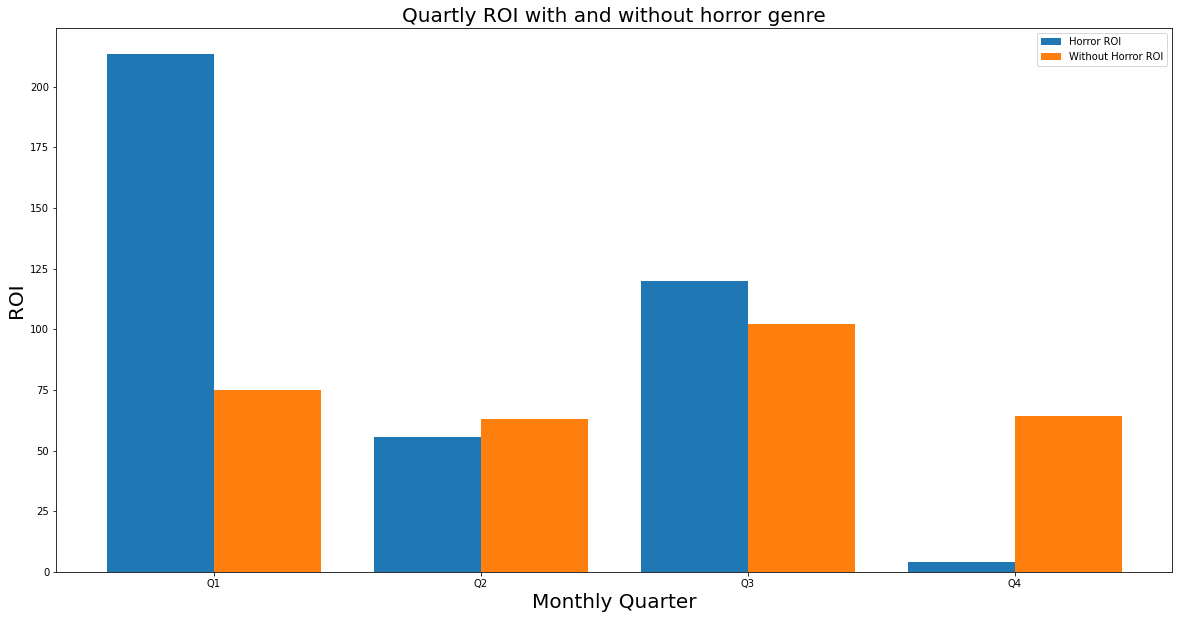

In [1032]:
quarter_roi_data = pd.merge(Horror_data, No_Horror_Data, how = "left", on = "Market Quarter" )

Horror_ROI = quarter_roi_data["Horror ROI"]
NO_Horror_ROI = quarter_roi_data["No Horror ROI"]
fig, ax = plt.subplots(figsize = (20,10))
X_axis = np.arange(len(NO_Horror_ROI))
plt.bar(X_axis - 0.2, Horror_ROI, 0.4, label = 'Horror ROI')
plt.bar(X_axis + 0.2, NO_Horror_ROI, 0.4, label = 'Without Horror ROI')
plt.xticks(X_axis, ["Q1", "Q2", "Q3", "Q4"])
plt.legend()
plt.ylabel('ROI', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Quartly ROI with and without horror genre", fontsize = 20);


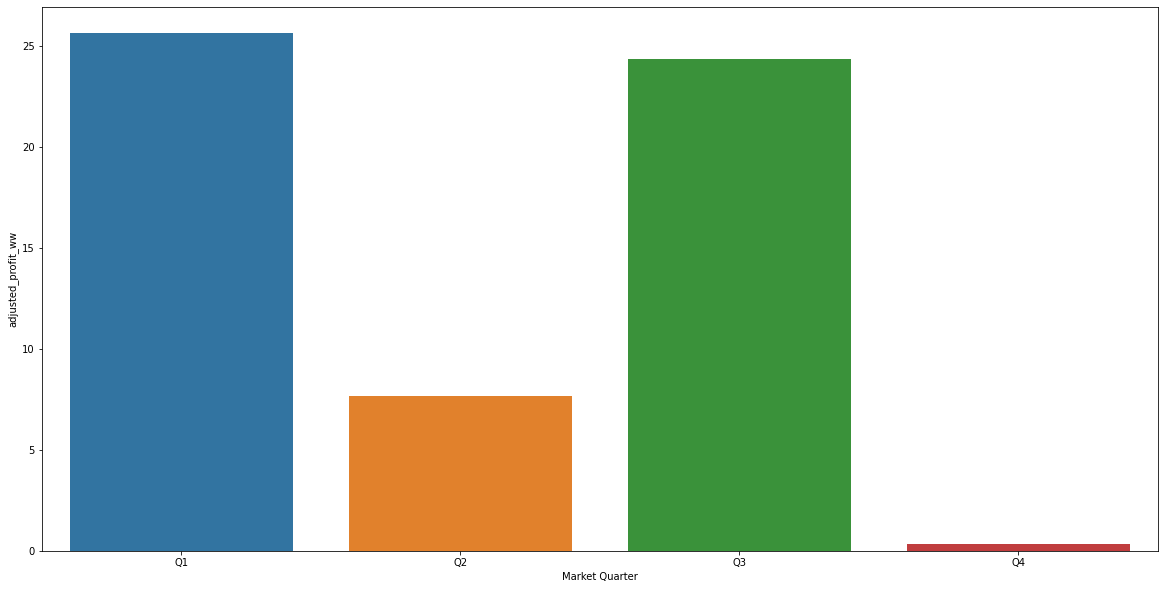

In [1033]:
quarter_horror_profit = explode[explode['genres'] =='Horror'].groupby('Market Quarter').median().reset_index()

fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'adjusted_profit_ww', data= quarter_horror_profit);

In [1034]:
explode.loc[(explode['genres'] =='Horror') & (explode["Market Quarter"] == "Q1")].sort_values(by = "ROI")

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI,runtime_minutes,genres,Market Quarter
6466,87,2015-02-03,Bleeding Hearts,1.20,0.000000,0.000000,-1.200000,-1.200000,-1.200000,2,2015,Tuesday,-1.371902,1.371902,-100.000000,100.0,Horror,Q1
6960,63,2015-03-10,Teeth and Blood,0.30,0.000000,0.000000,-0.300000,-0.300000,-0.300000,3,2015,Tuesday,-0.342975,0.342975,-100.000000,96.0,Horror,Q1
5928,68,2015-03-17,Something Wicked,3.00,0.000000,0.000000,-3.000000,-3.000000,-3.000000,3,2015,Tuesday,-3.429754,3.429754,-100.000000,95.0,Horror,Q1
5970,98,1956-01-12,Diane,2.66,0.000000,0.000000,-2.660000,-2.660000,-2.660000,1,1956,Thursday,-26.499272,26.499272,-100.000000,82.0,Horror,Q1
6231,96,2015-03-20,The Walking Deceased,2.00,0.000000,0.000000,-2.000000,-2.000000,-2.000000,3,2015,Friday,-2.286503,2.286503,-100.000000,88.0,Horror,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290,70,2014-01-03,Paranormal Activity: The Marked Ones,5.00,32.462372,90.904854,85.904854,27.462372,53.442482,1,2014,Friday,98.327412,5.723042,1718.097080,84.0,Horror,Q1
5248,54,2016-03-11,10 Cloverfield Lane,5.00,72.082999,108.286422,103.286422,67.082999,31.203423,3,2016,Friday,116.611273,5.645044,2065.728440,103.0,Horror,Q1
6921,28,1980-01-01,Maniac,0.35,10.000000,10.000000,9.650000,9.650000,-0.350000,1,1980,Tuesday,31.733744,1.150965,2757.142857,160.0,Horror,Q1
5238,49,2017-02-24,Get Out,5.00,176.040665,255.367951,250.367951,171.040665,74.327286,2,2017,Friday,276.771392,5.527293,5007.359020,104.0,Horror,Q1


In [1035]:
low_budget_df = explode.loc[(explode["adjusted_budget"] < (median_budget/3))]
low_budget_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_worldwide,profit_domestic,profit_international,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI,runtime_minutes,genres,Market Quarter
4932,90,2018-03-16,I Can Only Imagine,7.0000,83.482352,85.604221,78.604221,76.482352,-4.878131,3,2018,Friday,84.821951,7.553712,1122.917443,110.0,Biography,Q1
4932,90,2018-03-16,I Can Only Imagine,7.0000,83.482352,85.604221,78.604221,76.482352,-4.878131,3,2018,Friday,84.821951,7.553712,1122.917443,110.0,Drama,Q1
4932,90,2018-03-16,I Can Only Imagine,7.0000,83.482352,85.604221,78.604221,76.482352,-4.878131,3,2018,Friday,84.821951,7.553712,1122.917443,110.0,Family,Q1
4933,91,2019-03-15,Five Feet Apart,7.0000,45.729221,80.504421,73.504421,38.729221,27.775200,3,2019,Friday,77.907090,7.419277,1050.063157,116.0,Drama,Q1
4933,91,2019-03-15,Five Feet Apart,7.0000,45.729221,80.504421,73.504421,38.729221,27.775200,3,2019,Friday,77.907090,7.419277,1050.063157,116.0,Romance,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7216,78,2018-12-31,Red 11,0.0070,0.000000,0.000000,-0.007000,-0.007000,-0.007000,12,2018,Monday,-0.007554,0.007554,-100.000000,77.0,Sci-Fi,Q4
7216,78,2018-12-31,Red 11,0.0070,0.000000,0.000000,-0.007000,-0.007000,-0.007000,12,2018,Monday,-0.007554,0.007554,-100.000000,77.0,Thriller,Q4
7219,81,2015-09-29,A Plague So Pleasant,0.0014,0.000000,0.000000,-0.001400,-0.001400,-0.001400,9,2015,Tuesday,-0.001601,0.001601,-100.000000,76.0,Drama,Q4
7219,81,2015-09-29,A Plague So Pleasant,0.0014,0.000000,0.000000,-0.001400,-0.001400,-0.001400,9,2015,Tuesday,-0.001601,0.001601,-100.000000,76.0,Horror,Q4
